In [6]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



In [ ]:
# %%bash

# filelist=("sam_vit_b_01ec64.pth" "sample_data")

# pat=$(printf "^%s$" "${filelist[@]}")
# pat=${pat:1}


# ls | grep -Ev "$pat" | xargs rm -rf

In [2]:
!ls

In [ ]:
# %%bash

# # Variables
# REPO_URL="https://github.com/LIMAMMohamedlimam/sammed-lite.git"
# CLONE_DIR="temp_repo"
# TARGET_DIR="./"
# git clone "$REPO_URL" "$CLONE_DIR"

# # Create target directory if it doesn't exist
# mkdir -p "$TARGET_DIR"

# # Copy all contents (including hidden files)
# cp -r "$CLONE_DIR"/. "$TARGET_DIR"/

# # Delete cloned repo directory
# rm -rf "$CLONE_DIR"

# echo "Done: copied repo content into $TARGET_DIR"

Done: copied repo content into ./


Cloning into 'temp_repo'...


In [4]:
!ls

data_demo	  __pycache__	       segment_anything
DataLoader.py	  SAMMed2D-lite.ipynb  train.py
LitePredictor.py  SAMMed2DLite.py      utils.py


In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading SAM model

In [8]:
from SAMMed2DLite import SAMMed2DLite

In [9]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-11-25 17:08:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   350MB/s    in 1.0s    

2025-11-25 17:08:25 (350 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [10]:
from segment_anything import sam_model_registry

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

# Load base SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

*******interpolate
*******load sam_vit_b_01ec64.pth


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Adapted_Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (adapter_layer): Adapter_Layer(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (channel): Sequential(
            (0): Linear(in_features=768, out_features=192, bias=False)
            (1): ReLU()
            (2): Linear(in_features=192, out_features=768, bias=False)
            (3): Sigmoid()
          )
          (spatial): Sequential(
            (0): Conv2d(768, 768, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): ReLU()
            (2): ConvTranspose2d(768, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (3): ReLU()
          )
        )
        (att

In [11]:
model = SAMMed2DLite(sam_model=sam).to(device)
print(f"Model loaded with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

Model loaded with 184,569,136 trainable parameters


## Datasets and Dataloaders

In [12]:
from DataLoader import DatasetLoader

In [13]:
import multiprocessing

def get_num_workers():
    cpu_count = multiprocessing.cpu_count()
    has_gpu = torch.cuda.is_available()
    if has_gpu:
        return min(2, cpu_count)
    else:
        return min(2, cpu_count)

num_workers = get_num_workers()

print("Using num_workers =", num_workers)


Using num_workers = 2


In [14]:
data_dir = "data_demo"
train_dataset = DatasetLoader(data_dir=data_dir)
test_dataset = DatasetLoader(data_dir=data_dir , mode=0)

training dataset loaded!
testing dataset loaded!


In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


In [16]:
num_epochs = 5

In [17]:
from train import train_model
#Train

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=num_epochs,
    learning_rate=1e-4,
    save_dir='checkpoints',
    device=device
)

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]



--- DEBUG REPORT ---
Total Samples: 11
Empty Predictions (All Black): 8
Empty Ground Truths (All Black): 0
--------------------

Epoch 1/5
Train Loss: 1.8072
Val Dice: 0.0000
Val IoU: 0.0000


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]



--- DEBUG REPORT ---
Total Samples: 11
Empty Predictions (All Black): 11
Empty Ground Truths (All Black): 0
--------------------

Epoch 2/5
Train Loss: 1.5278
Val Dice: 0.0000
Val IoU: 0.0000


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]



--- DEBUG REPORT ---
Total Samples: 11
Empty Predictions (All Black): 11
Empty Ground Truths (All Black): 0
--------------------

Epoch 3/5
Train Loss: 1.3249
Val Dice: 0.0000
Val IoU: 0.0000


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]



--- DEBUG REPORT ---
Total Samples: 11
Empty Predictions (All Black): 11
Empty Ground Truths (All Black): 0
--------------------

Epoch 4/5
Train Loss: 1.1809
Val Dice: 0.0000
Val IoU: 0.0000


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


--- DEBUG REPORT ---
Total Samples: 11
Empty Predictions (All Black): 11
Empty Ground Truths (All Black): 0
--------------------

Epoch 5/5
Train Loss: 1.2086
Val Dice: 0.0000
Val IoU: 0.0000


## Evaluation

In [18]:
from utils import evaluate_batch
# Load best checkpoint
try:
  checkpoint = torch.load('checkpoints/best_model.pth')
  model.load_state_dict(checkpoint['model_state_dict'])
except :
  print("failed loading")

# Run evaluation
test_metrics = evaluate_batch(model, test_loader, device)

print("\n=== Test Results ===")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"IoU: {test_metrics['iou']:.4f}")

failed loading


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


--- DEBUG REPORT ---
Total Samples: 11
Empty Predictions (All Black): 11
Empty Ground Truths (All Black): 0
--------------------

=== Test Results ===
Dice Coefficient: 0.0000
IoU: 0.0000


## training history plot

In [19]:

def plot_training_history(history, save_path='training_curves.png'):
    """Visualize training progress"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curve
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Metrics curves
    axes[1].plot(history['val_dice'], label='Dice', marker='o')
    axes[1].plot(history['val_iou'], label='IoU', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Validation Metrics')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

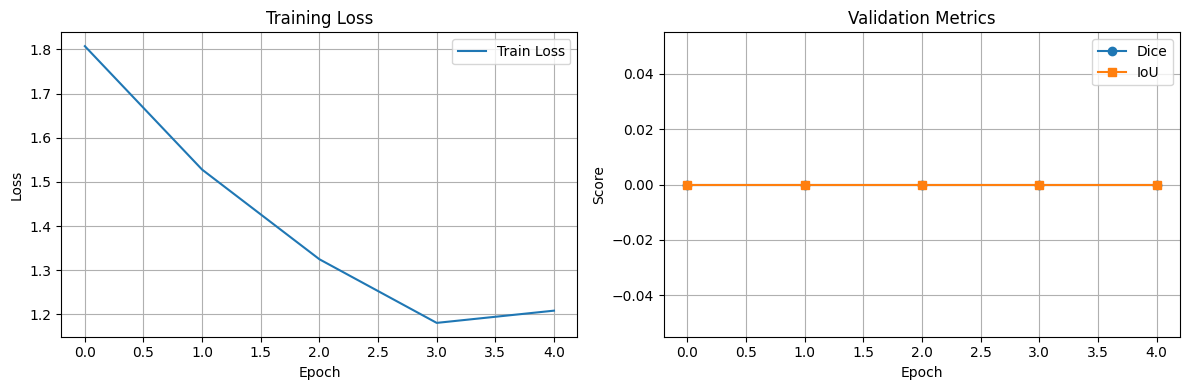

In [20]:
plot_training_history(history=history)

Generated BBox from mask: [np.int64(153), np.int64(237), np.int64(221), np.int64(294)]
Saved result to result_visualization.png


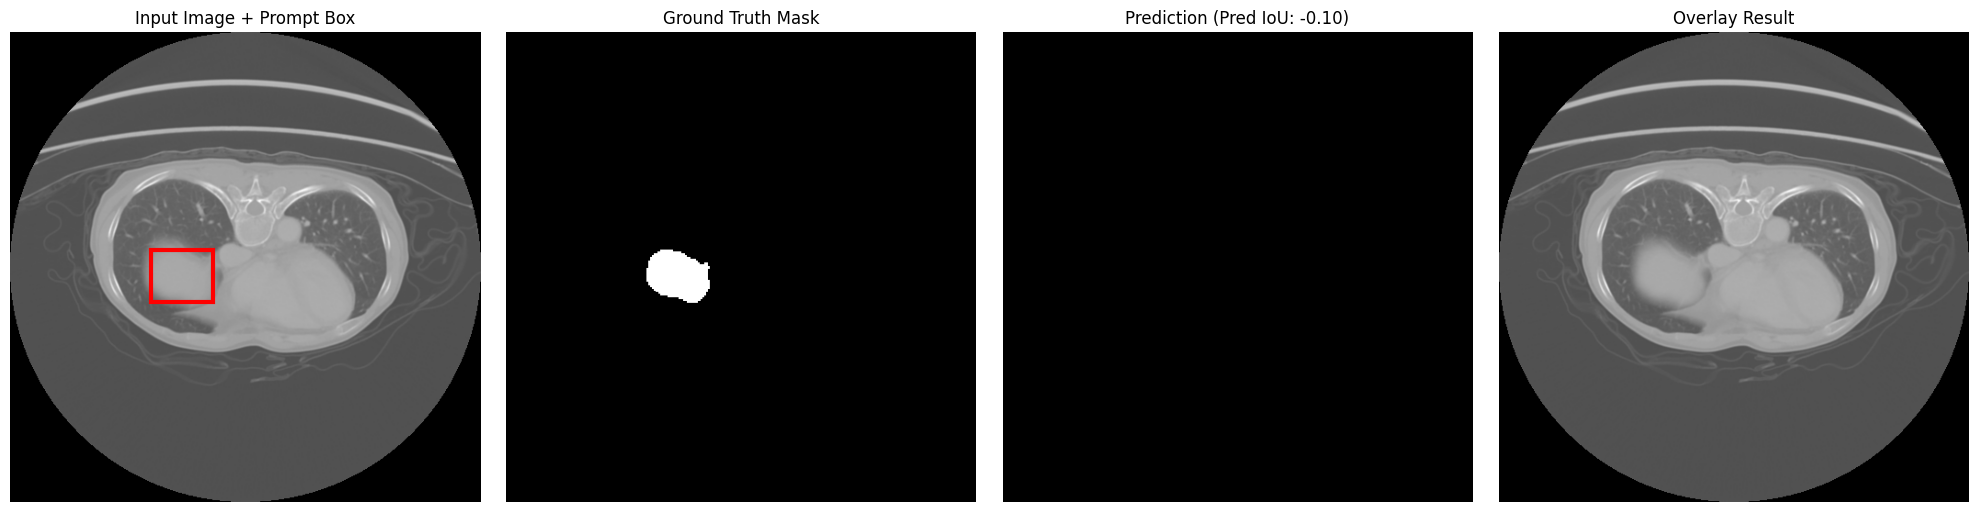

In [ ]:
from LitePredictor import get_bbox_from_mask_file , LitePredictor
mask_path = "data_demo/masks/amos_0004_75_liver_000.png"
img_path = "data_demo/images/amos_0004_75.png"  


bbox = get_bbox_from_mask_file(mask_path)
print(f"Generated BBox from mask: {bbox}")

predictor = LitePredictor(model, device)

predictor.visualize_prediction(
    image_path=img_path,
    bbox=bbox,
    gt_mask_path=mask_path,
    save_path="result_visualization.png"
)

In [29]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/finding-lungs-in-ct-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'finding-lungs-in-ct-data' dataset.
Path to dataset files: /kaggle/input/finding-lungs-in-ct-data


In [30]:
!ls /kaggle/input/finding-lungs-in-ct-data

2d_images      2d_masks      3d_images	    lung_stats.csv
2d_images.zip  2d_masks.zip  3d_images.zip


In [ ]:
import os
import json
import random

# 1. Define your paths based on the screenshot
base_dir = "/kaggle/input/finding-lungs-in-ct-data"
images_dir = os.path.join(base_dir, "2d_images")
masks_dir = os.path.join(base_dir, "2d_masks")

# 2. Get list of filenames (filtering for .tif to be safe)
# We assume filenames are identical in both folders as shown in your 'ls' command
all_filenames = [f for f in os.listdir(images_dir) if f.endswith('.tif')]

# 3. Shuffle the data for a random split
random.seed(42)  # Set seed for reproducibility
random.shuffle(all_filenames)

# 4. Calculate split index (80% for training)
split_index = int(len(all_filenames) * 0.8)

train_files = all_filenames[:split_index]
test_files = all_filenames[split_index:]

# 5. Create the dictionaries
train_map = {}
test_map = {}

# Build Train Map: Image Path -> Mask Path
for f in train_files:
    img_path = os.path.join(images_dir, f)
    mask_path = os.path.join(masks_dir, f)
    train_map[img_path] = mask_path

# Build Test Map: Mask Path -> Image Path (As requested: label2image)
for f in test_files:
    img_path = os.path.join(images_dir, f)
    mask_path = os.path.join(masks_dir, f)
    test_map[mask_path] = img_path

# 6. Save to JSON files
with open('image2label_train.json', 'w') as f:
    json.dump(train_map, f, indent=4)

with open('label2image_test.json', 'w') as f:
    json.dump(test_map, f, indent=4)

print(f"Total files: {len(all_filenames)}")
print(f"Training items (80%): {len(train_map)} saved to 'image2label_train.json'")
print(f"Testing items (20%): {len(test_map)} saved to 'label2image_test.json'")